# HoVer-Net Output

This repository enables the segmentation of nuclei in H&E whole-slide images (WSIs). For inference, we have incorporated two modes:

- Tile processing mode
- WSI processing mode

For tile processing, the input must be in a standard image format, such as `.jpg` or `.png`. <br />
For WSI processing, the input must be an [OpenSlide](https://openslide.org/) supported whole-slide image.

- Both tile and wsi processing modes output a `.json` file that contains:
        - bounding box coordinates for each nucleus
        - centroid coordinates for each nucleus
        - contour coordinates for each nucleus 
        - nucleus type predictions
        - per class probabilities for each nucleus (optional)
- tile mode also output a `.mat` and overlay file. The `.mat` file contains:
        - raw output of network (optional)
        - instance map containing values from 0 to N, where N is the number of nuclei
        - list of length N containing predictions for each nucleus

In this notebook, we demonstrate how to utilise the output generated by these two different settings.

In [2]:
# load the libraries

import sys
sys.path.append('../')

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import scipy.io as sio
import cv2
import json
import openslide

from misc.wsi_handler import get_file_handler
from misc.viz_utils import visualize_instances_dict

In [7]:
# first, we shall set the image tile, WSI and output paths.

tile_path = '../dataset/sample_tiles/imgs/'
tile_json_path = '../dataset/sample_tiles/pred/json/'
tile_mat_path = '../dataset/sample_tiles/pred/mat/'
tile_overlay_path = '../dataset/sample_tiles/pred/overlay/'
wsi_path = '../dataset/sample_wsis/wsi/'
wsi_json_path = '../dataset/sample_wsis/out/'

## Tile Processing Output

First let's view the 2D output from tile processing mode, that is stored in a `.mat` file.

In [31]:
# load the original image, the `.mat` file and the overlay

image_list = glob.glob(tile_path + '*.tif')
image_list.sort()

# get a random image 
rand_nr = np.random.randint(0,len(image_list))
image_file = image_list[rand_nr]

basename = os.path.basename(image_file)
image_ext = basename.split('.')[-1]
basename = basename[:-(len(image_ext)+1)]

image = cv2.imread(image_file)
# convert from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# get the corresponding `.mat` file 
result_mat = sio.loadmat(tile_mat_path + basename + '.mat')

# get the overlay
overlay = cv2.imread(tile_overlay_path + basename + '.png')
overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

In [33]:
# ** now, let's get the outputs and print some basic shape information
# 2D map where each nucleus has a unique ID assigned. 0 is background
inst_map = result_mat['inst_map'] 
# Nx2 length array denoting nuclear type predictions. N is the number of nuclei
# idx=0 denotes the corresponding inst_id in the `inst_map` and 
# idx=1 denotes the type of that inst_id
inst_type = result_mat['inst_type'] 

print('instance map shape', inst_map.shape)
# double check the number of instances is the same as the number of type predictions
print('number of instances', len(np.unique(inst_map)[1:].tolist()))
print('number of type predictions', len(np.unique(inst_type[:,1])))
print('overlay shape', overlay.shape)

instance map shape (1000, 1000)
number of instances 336
number of type predictions 6
overlay shape (1000, 1000, 3)


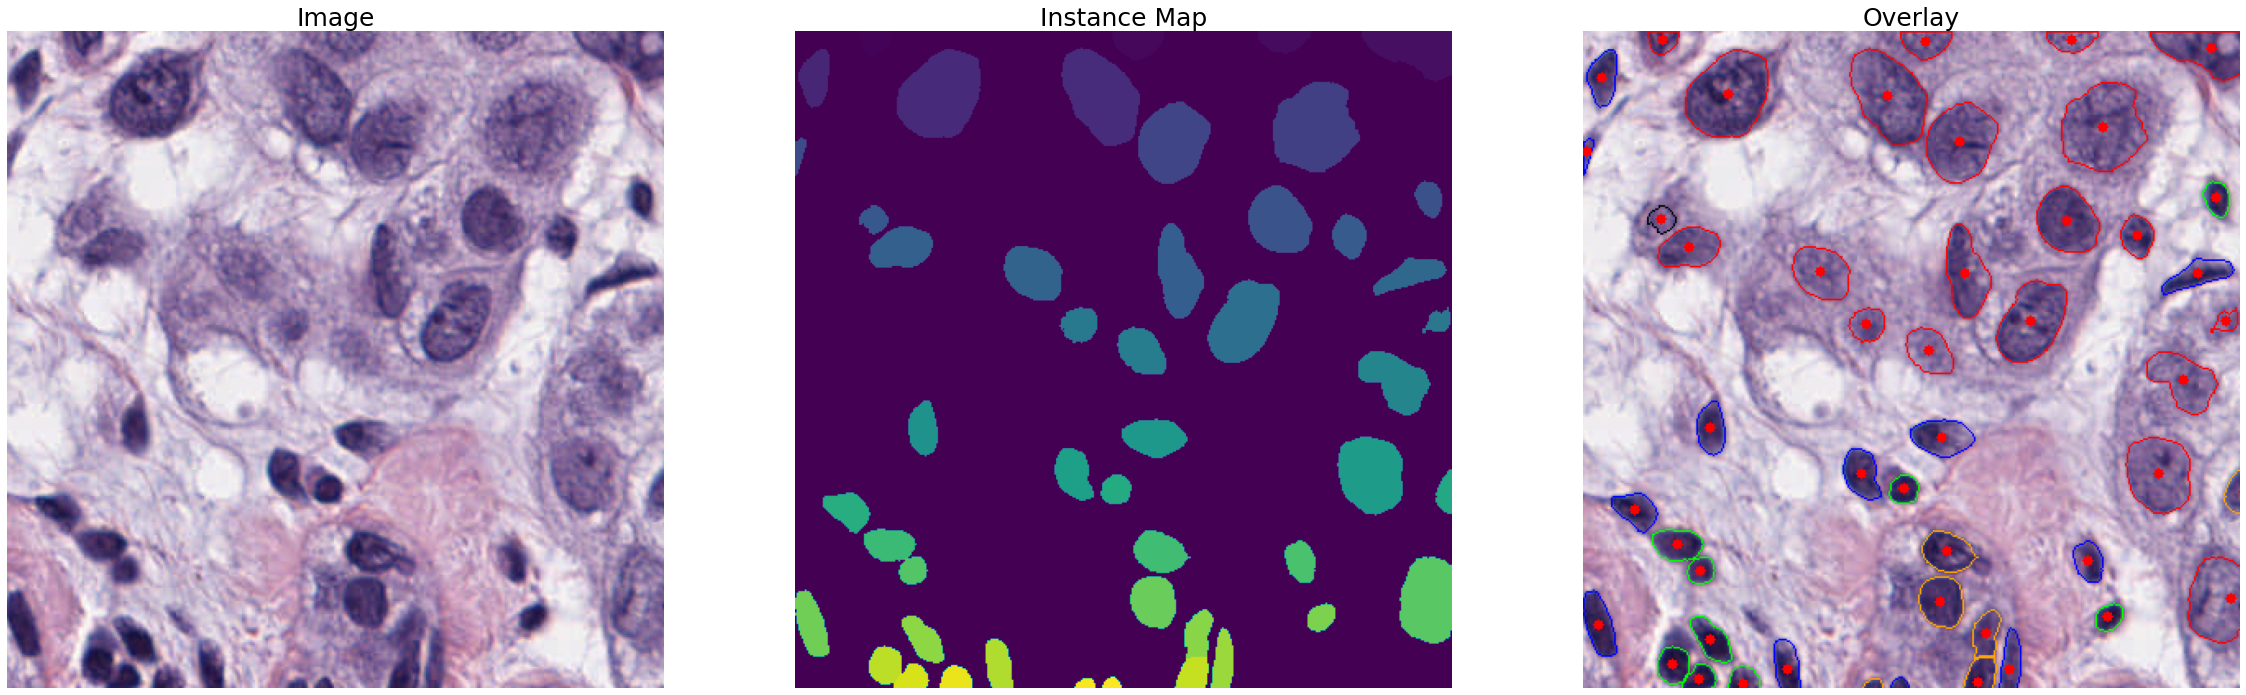

In [34]:
# plot the original image, along with the instance map and the overlay

plt.figure(figsize=(40,20))

plt.subplot(1,3,1)
plt.imshow(image[:400,:400,:])
plt.axis('off')
plt.title('Image', fontsize=25)

plt.subplot(1,3,2)
plt.imshow(inst_map[:400,:400])
plt.axis('off')
plt.title('Instance Map', fontsize=25)

plt.subplot(1,3,3)
plt.imshow(overlay[:400,:400,:])
plt.axis('off')
plt
plt.title('Overlay', fontsize=25)

plt.show()

In [37]:
# let's inspect the inst_type output

print(np.unique(inst_type[:,1]))

[0 1 2 3 4 5]


We observe that the values range from 0 (background) to N where N is the number of classes. See below what these values refer to for different datasets.

## CoNSeP

1) Epithelial <br />
2) Inflammatory <br />
3) Spindle-Shaped <br />
4) Miscellaneous

## PanNuke

1) Neoplastic <br />
2) Inflammatory <br />
3) Connective <br />
4) Dead <br />
5) Non-Neoplastic Epithelial 

## MoNuSAC

1) Epithelial <br />
2) Lymphocyte <br />
3) Macrophage <br />
4) Neutrophil

Now, let's view the contents of the `.json` file.

In [38]:
# load the json file and add the contents to corresponding lists

json_path = tile_json_path + basename + '.json'

bbox_list = []
centroid_list = []
contour_list = [] 
type_list = []

with open(json_path) as json_file:
    data = json.load(json_file)
    mag_info = data['mag']
    nuc_info = data['nuc']
    for inst in nuc_info:
        inst_info = nuc_info[inst]
        inst_centroid = inst_info['centroid']
        centroid_list.append(inst_centroid)
        inst_contour = inst_info['contour']
        contour_list.append(inst_contour)
        inst_bbox = inst_info['bbox']
        bbox_list.append(inst_bbox)
        inst_type = inst_info['type']
        type_list.append(inst_type)

In [8]:
# get the number of items in each list

print('Number of centroids', len(centroid_list))
print('Number of contours', len(contour_list))
print('Number of bounding boxes', len(bbox_list))

# each item is a list of coordinates - let's take a look!
print('-'*60)
print(centroid_list[0])
print('-'*60)
print(contour_list[0])
print('-'*60)
print(bbox_list[0])

Number of centroids 384
Number of contours 384
Number of bounding boxes 384
------------------------------------------------------------
[66.4, 10.076]
------------------------------------------------------------
[[65, 0], [65, 3], [63, 5], [63, 6], [61, 8], [61, 9], [60, 10], [60, 11], [59, 12], [59, 13], [58, 14], [58, 17], [59, 18], [59, 19], [60, 20], [61, 20], [62, 21], [66, 21], [68, 19], [68, 17], [69, 16], [69, 15], [70, 14], [70, 13], [72, 11], [72, 10], [73, 9], [73, 8], [74, 7], [74, 5], [75, 4], [75, 0], [67, 0], [66, 1]]
------------------------------------------------------------
[[0, 58], [22, 76]]


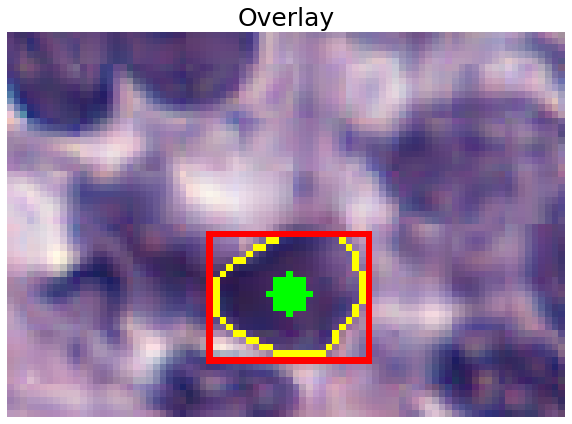

In [39]:
# get a single contour, bounding box and centroid and visualise

rand_nucleus = np.random.randint(0, len(centroid_list))
rand_centroid = centroid_list[rand_nucleus]
rand_bbox = bbox_list[rand_nucleus]
rand_contour = contour_list[rand_nucleus]

overlay = image.copy()
overlay = cv2.drawContours(overlay.astype('uint8'), [np.array(rand_contour)], -1, (255,255,0), 1)
overlay = cv2.circle(overlay.astype('uint8'),(np.round(rand_centroid[0]).astype('int'), np.round(rand_centroid[1]).astype('int')), 3, (0,255,0), -1)
overlay = cv2.rectangle(overlay.astype('uint8'), (rand_bbox[0][1], rand_bbox[0][0]), (rand_bbox[1][1], rand_bbox[1][0]), (255,0,0), 1)

pad = 30
crop1 = rand_bbox[0][0]-pad
if crop1 < 0: 
    crop1 = 0
crop2 = rand_bbox[1][0]+pad
if crop2 > overlay.shape[0]: 
    crop2 = overlay.shape[0]
crop3 = rand_bbox[0][1]-pad
if crop3 < 0: 
    crop3 = 0
crop4 = rand_bbox[1][1]+pad
if crop4 > overlay.shape[1]: 
    crop4 = overlay.shape[1]
crop_overlay = overlay[crop1:crop2,crop3:crop4,:]
plt.figure(figsize=(10,10))

plt.imshow(crop_overlay)
plt.axis('off')
plt.title('Overlay', fontsize=25)
plt.show()

## WSI Processing Output

For WSI processing, our output is in json format and therefore we can apply a similar technique to what we saw above to extract the instance information.

Below we will show how to get a tile from a processed WSI and display the corresponding overlay.

In [8]:
wsi_list = glob.glob(wsi_path + '*')

# get a random image 
rand_wsi = np.random.randint(0,len(wsi_list))
wsi_file = wsi_list[rand_wsi]
wsi_ext = '.svs'

wsi_basename = os.path.basename(wsi_file)
wsi_basename = wsi_basename[:-(len(wsi_ext)+1)]

print(wsi_file)
wsi_obj = get_file_handler(wsi_file, wsi_ext)

json_path_wsi = wsi_json_path + wsi_basename + '.json'

../dataset/sample_wsis/wsi/TCGA-CA-5255-01Z-00-DX1.77310ae2-9c5f-48c4-9754-c5b30d287089.svs


In [10]:
# load the json file

bbox_list_wsi = []
centroid_list_wsi = []
contour_list_wsi = [] 
type_list_wsi = []

json_path_wsi = '/home/tialab-dang/workspace/project/hover_net/dataset/sample_wsis/out/TCGA-CA-5255-01Z-00-DX1.77310ae2-9c5f-48c4-9754-c5b30d287089.json'
with open(json_path_wsi) as json_file:
    data = json.load(json_file)
    mag_info = data['mag']
    nuc_info = data['nuc']
    for inst in nuc_info:
        inst_info = nuc_info[inst]
        inst_centroid = inst_info['centroid']
        centroid_list_wsi.append(inst_centroid)
        inst_contour = inst_info['contour']
        contour_list_wsi.append(inst_contour)
        inst_bbox = inst_info['bbox']
        bbox_list_wsi.append(inst_bbox)
        inst_type = inst_info['type']
        type_list_wsi.append(inst_type)
print(mag_info)

In [50]:
# let's generate a tile from the image and overlay the corresponding predicted contours for that tile

# read in an image
x_tile = 2000
y_tile = 2000
w_tile = 2000
h_tile = 2000
wsi_obj.prepare_reading(read_mag=mag_info)
wsi_tile = wsi_obj.read_region((x_tile,y_tile), (w_tile,h_tile))

coords_xmin = x_tile
coords_xmax = x_tile + w_tile
coords_ymin = y_tile
coords_ymax = y_tile + h_tile

contour_tile_dict = {}
idx = 0
for cnt in contour_list:
    cnt_tmp = np.array(cnt)
    cnt_tmp = cnt_tmp[(cnt_tmp[:,0] >= coords_xmin) & (cnt_tmp[:,0] <= coords_xmax) & (cnt_tmp[:,1] >= coords_ymin) & (cnt_tmp[:,1] <= coords_ymax)] 
    if cnt_tmp.shape[0] > 0:
        cnt_adj = np.round(cnt_tmp - np.array([x_tile,y_tile])).astype('int')
        contour_tile_dict[idx] = {'contour': cnt_adj}
        idx += 1

None


TypeError: '>' not supported between instances of 'NoneType' and 'float'

In [ ]:
# plot the overlay

plt.figure(figsize=(18,15))
overlaid_output = visualize_instances_dict(wsi_tile, contour_tile_dict, model_name='pannuke')
plt.imshow(overlaid_output)
plt.axis('off')
plt.title('Segmentation Overlay')
plt.show()